## GDP `(Gross Domestic Product)` forecast or estimate `(million US$)` by country 📈📑

In [207]:
from bs4 import BeautifulSoup
import requests as req
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json

## Data collection `(Web Scraping)`  

In [208]:
#Send request to wikipedia to access html page
#define source url
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)'
#define browser agent
headers = {
    "User-Agent": "Mozilla/5.0"
}
#send request and store responsed data into response
response = req.get(url,headers=headers)
#check connection status, it must be 200
print(response.status_code)

200


>## since status code is 200, that`s mean that connecting geting successfully 👌🚀
>### Now let`s select our table structure info using BeatifulSoup  

In [209]:
#Reading html page content
page = BeautifulSoup(response.text, 'html.parser')
#find our table element here
table = page.find_all('table', class_ = 'wikitable')[0]
#get all table columns (th)
table_columns = table.find_all('th')
#store table columns titles into list
table_columns = [col.text.strip() for col in table_columns]
table_columns = [re.sub(r'[^a-zA-Z]+', '', col) for col in table_columns]
# print(table_columns)
#select categories columns [IMF, WorldBank, UnitedNations]
table_categories = table_columns[1:4]
for cat in table_categories:
    table_columns.remove(cat)
# print(table_columns)

#create dataframe schema
df = pd.DataFrame(columns=table_columns)

#get all table rows
table_rows = table.find_all('tr')
for row in table_rows[2:]:
    table_data = row.find_all('td')
    table_data = [data.text.strip() for data in table_data]

    #replace dash (—, -, –) with two NaN values (Forecast + Year)
    cleaned_row = []
    i = 0
    while i < len(table_data):
        val = table_data[i]
        if val in ['—', '-', '–']:
            cleaned_row.extend([np.nan, np.nan])
            i += 1
        else:
            cleaned_row.append(val)
            i += 1
    # print(cleaned_row)

    #ensure that the length of each row of data is equal to length of columns
    while len(cleaned_row) < len(table_columns):
        cleaned_row.append(np.nan)
    cleaned_row = cleaned_row[:len(table_columns)]
    # print(len(cleaned_row))

    df.loc[len(df)] = cleaned_row #insert data into dataframe

#divide columns by category source
df.columns = [
    "Country",
    "IMF_Forecast",
    "IMF_Year",
    "WorldBank_Estimate",
    "WorldBank_Year",
    "UnitedNations_Estimate",
    "UnitedNations_Year"
]

df.head()

,Country,IMF_Forecast,IMF_Year,WorldBank_Estimate,WorldBank_Year,UnitedNations_Estimate,UnitedNations_Year
0,World,"113,795,678",2025,"111,326,370",2024,"100,834,796",2022
1,United States,"30,507,217",2025,"29,184,890",2024,"27,720,700",2023
2,China,"19,231,705",[n 1]2025,"18,743,803",[n 3]2024,"17,794,782",[n 1]2023
3,Germany,"4,744,804",2025,"4,659,929",2024,"4,525,704",2023
4,India,"4,187,017",2025,"3,912,686",2024,"3,575,778",2023


## Explore & Understanding the data 🔎📑

In [210]:
#first 5 rows
print(df.head())
#last 5 rows
print(df.tail())
#info about dataset
print(df.info())
#describe columns in transpose way
print(df.describe().T)

         Country IMF_Forecast   IMF_Year WorldBank_Estimate WorldBank_Year  \
0          World  113,795,678       2025        111,326,370           2024   
1  United States   30,507,217       2025         29,184,890           2024   
2          China   19,231,705  [n 1]2025         18,743,803      [n 3]2024   
3        Germany    4,744,804       2025          4,659,929           2024   
4          India    4,187,017       2025          3,912,686           2024   

  UnitedNations_Estimate UnitedNations_Year  
0            100,834,796               2022  
1             27,720,700               2023  
2             17,794,782          [n 1]2023  
3              4,525,704               2023  
4              3,575,778               2023  
              Country IMF_Forecast IMF_Year WorldBank_Estimate WorldBank_Year  \
217          Kiribati          312     2025                308           2024   
218  Marshall Islands          297     2025                280           2024   
219         

>### Check duplication and missing values before cleaning the dataset !🔎🛠️

In [211]:
#check duplication
print(df.duplicated().sum())
#checking missing values
print(df.isna().values.sum())
#check number the of rows that have missing values
print(df[df.isna().any(axis=1)].count().max())

0
106
36


In [212]:
#check missing values into each column
cols = df.columns
for col in cols:
    print(f'The number of missing values in col {col} is: {df[col].isna().values.sum()}\n')

The number of missing values in col Country is: 0

The number of missing values in col IMF_Forecast is: 32

The number of missing values in col IMF_Year is: 32

The number of missing values in col WorldBank_Estimate is: 12

The number of missing values in col WorldBank_Year is: 12

The number of missing values in col UnitedNations_Estimate is: 9

The number of missing values in col UnitedNations_Year is: 9



### So, null values is 106 values distributed on 36 rows of coutries

## Data Cleaning 🪮📑
> ### Handel missing values

In [213]:
#Replace missing with Forward Fill
df.ffill(inplace=True)

In [214]:
#checking missing values again
print(df.isna().values.sum())
#check number the of rows that have missing values agin
print(df[df.isna().any(axis=1)].count().max())

0
0


# NOTE:
## forecast and year columns are an object `(string)`,
>#### but it must be numaric so, first i will ensure that all data is only continous digits
## Determination values prolems:
- there is values contains `[char, digit]`
- remove ',' from `forecast`, `Estimate`
> ## So, i will define a function that solve this two problems 👌

In [215]:
#define function to solve data problems
def clear_data(val):
    if isinstance(val, str):
        val = re.sub(r'\[.*?\]', '', val)
        val = re.sub(r'[^0-9]', '', val)
    return val

In [216]:
#apply function on forecast and year, Estimate columns
forecast_est_year = df.columns[
    df.columns.str.contains('Forecast') |
    df.columns.str.contains('Year') |
    df.columns.str.contains('Estimate')
]
for col in forecast_est_year:
    df[col] = df[col].apply(clear_data)
df.head()

,Country,IMF_Forecast,IMF_Year,WorldBank_Estimate,WorldBank_Year,UnitedNations_Estimate,UnitedNations_Year
0,World,113795678,2025,111326370,2024,100834796,2022
1,United States,30507217,2025,29184890,2024,27720700,2023
2,China,19231705,2025,18743803,2024,17794782,2023
3,Germany,4744804,2025,4659929,2024,4525704,2023
4,India,4187017,2025,3912686,2024,3575778,2023


In [217]:
#Correct columns dtypes
data_cols = df.columns[1:]
for col in data_cols:
    if "Year" in col:
        df[col] = df[col].astype(np.int64)
    else:
      df[col] = df[col].astype(np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, 0 to 221
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 222 non-null    object 
 1   IMF_Forecast            222 non-null    float64
 2   IMF_Year                222 non-null    int64  
 3   WorldBank_Estimate      222 non-null    float64
 4   WorldBank_Year          222 non-null    int64  
 5   UnitedNations_Estimate  222 non-null    float64
 6   UnitedNations_Year      222 non-null    int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 22.0+ KB


In [218]:
# Create log-transformed columns to reduce skewness
# and compress large gaps between GDP values
df['Log_IMF'] = np.log1p(df['IMF_Forecast'])
df['Log_WB'] = np.log1p(df['WorldBank_Estimate'])
df['Log_UN'] = np.log1p(df['UnitedNations_Estimate'])

In [219]:
#filter (IMF_Forecast, WorldBank_Estimate, UN_Estimate) columns in orginal for visualization
forecast_est = df.columns[
    df.columns.str.contains('Forecast') |
    df.columns.str.contains('Estimate')
]
# forecast_est
#filter (IMF_Forecast, WorldBank_Estimate, UN_Estimate) columns in orginal for Statistical states
log_forecast_est = df.columns[
    df.columns.str.contains('Log')
]
# log_forecast_est

In [220]:
from logging import log
#Create Average_GDP Feature that take mean of Normal GDP
df["Average_Normal_GDP"] = df[forecast_est].mean(axis=1)
#Create Average_Log_GDP Feature that take mean of Log GDP
df["Average_Log_GDP"] = df[log_forecast_est].mean(axis=1)

In [221]:
#Summary Statistics
summary = {
    "Max GDP": df["Average_Normal_GDP"].max(),
    "Min GDP": df["Average_Normal_GDP"].min(),
    "Mean GDP": df["Average_Normal_GDP"].mean(),
    "Std Dev": df["Average_Normal_GDP"].std()
}
pd.DataFrame(summary, index=[0])
df.head()

,Country,IMF_Forecast,IMF_Year,WorldBank_Estimate,WorldBank_Year,UnitedNations_Estimate,UnitedNations_Year,Log_IMF,Log_WB,Log_UN,Average_Normal_GDP,Average_Log_GDP
0,World,113795678.0,2025,111326370.0,2024,100834796.0,2022,18.549915,18.527977,18.428994,1.086523e+08,18.502295
1,United States,30507217.0,2025,29184890.0,2024,27720700.0,2023,17.233474,17.189162,17.137690,2.913760e+07,17.186775
2,China,19231705.0,2025,18743803.0,2024,17794782.0,2023,16.772071,16.746374,16.694416,1.859010e+07,16.737620
3,Germany,4744804.0,2025,4659929.0,2024,4525704.0,2023,15.372561,15.354511,15.325284,4.643479e+06,15.350785
4,India,4187017.0,2025,3912686.0,2024,3575778.0,2023,15.247499,15.179735,15.089694,3.891827e+06,15.172309


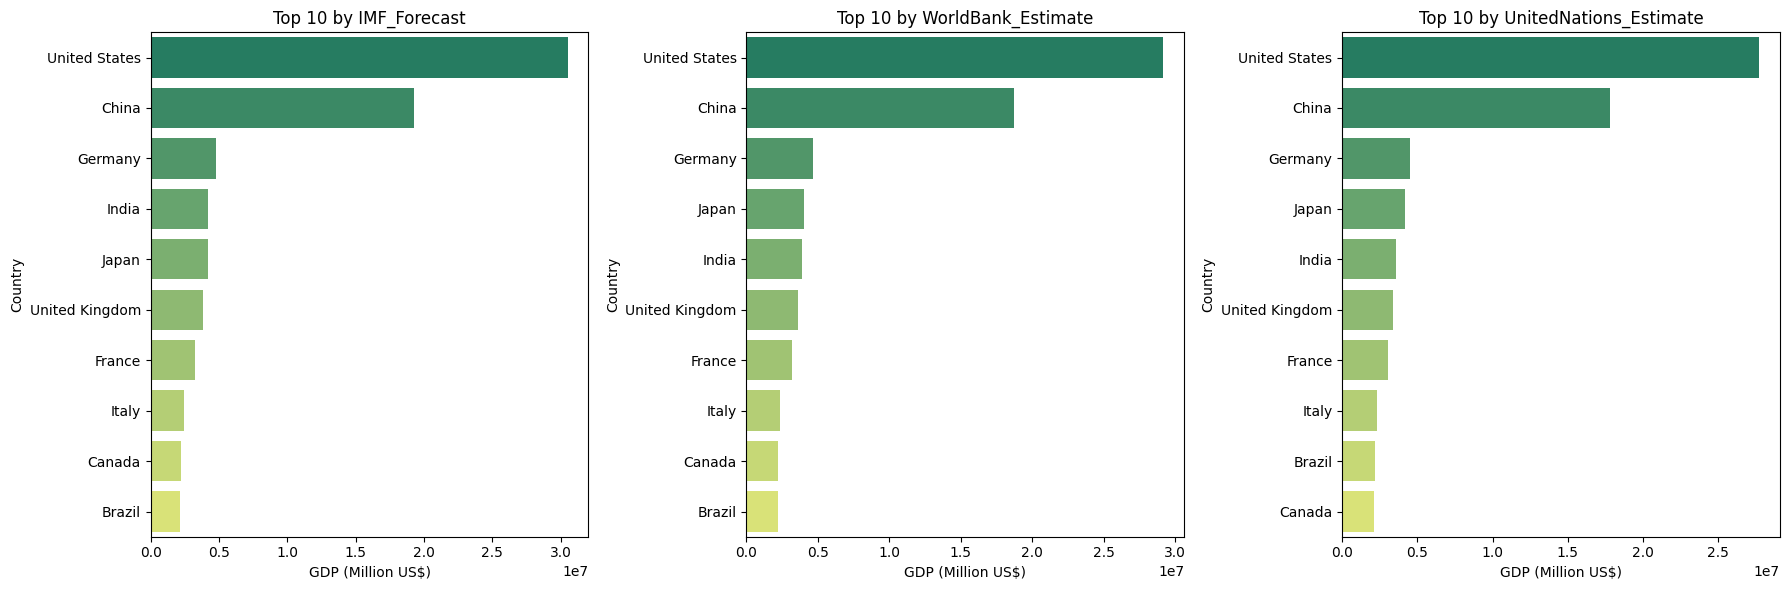

In [222]:
#Top 10 countries by GDP (IMF_Forecast, WorldBank_Estimate, UN_Estimate)

# Create subplots
fig, axes = plt.subplots(1, len(forecast_est), figsize=(18, 6))

#Loop on each GDP column and plot Top 10
for i, col in enumerate(forecast_est):
    top_10 = (df[['Country', col]].sort_values(by=col, ascending=False)).head(11)[1:]

    #Plot with seaborn
    sns.barplot(
        data=top_10,
        x=col,
        y="Country",
        hue='Country',
        palette="summer",
        ax=axes[i]
    )

    axes[i].set_title(f"Top 10 by {col}")
    axes[i].set_xlabel("GDP (Million US$)")
plt.tight_layout()
plt.show()

In [223]:
# Compare GDP values across IMF, World Bank, and United Nations for each country in the top countries
top_10_con = df['Country'].head(11)[1:11]
top_10 = df.groupby('Country')[forecast_est].mean().loc[top_10_con]
top_10

px.bar(
    data_frame=top_10,
    title='Compare GDP values across IMF, World Bank, and United Nations',
    height=550,
    barmode='group',
    width=1200,
    color_discrete_sequence=px.colors.qualitative.Dark2
)

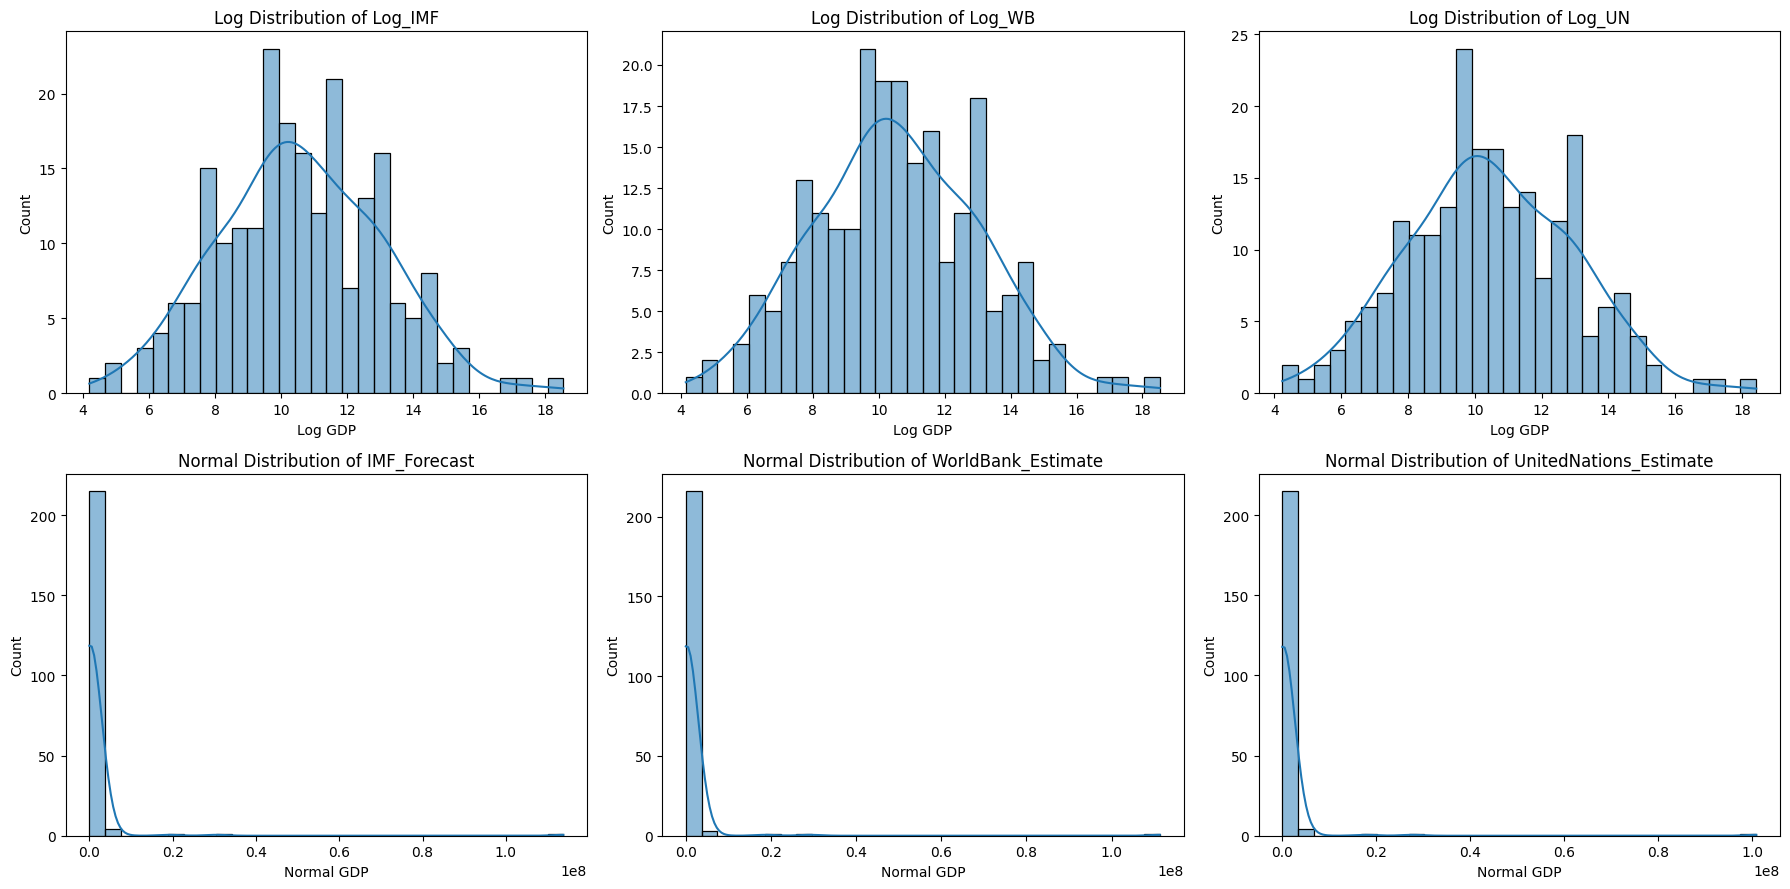

In [224]:
#distribution of GDP values to check skewness normal and log distribution
fig, axes = plt.subplots(2, len(forecast_est), figsize=(18, 9))

axes = axes.flatten()

for i, col in enumerate(log_forecast_est):
    sns.histplot(
        data=df[col],
        ax=axes[i],
        bins=30,
        kde=True
    )
    axes[i].set_title(f"Log Distribution of {col}")
    axes[i].set_xlabel("Log GDP")
    axes[i].set_ylabel("Count")

for i, col in enumerate(forecast_est):
    sns.histplot(
        data=df[col],
        ax=axes[i + len(forecast_est)],
        bins=30,
        kde=True
    )
    axes[i + len(forecast_est)].set_title(f"Normal Distribution of {col}")
    axes[i + len(forecast_est)].set_xlabel("Normal GDP")
    axes[i + len(forecast_est)].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [225]:
# select gdp column
col = "IMF_Forecast"

# select all coutries exept world row
df_clean = df[df["Country"] != "World"]

# total gdp sum
total_gdp = df_clean[col].sum()

# top 10 countries
top10 = (df_clean[['Country', col]].sort_values(by=col, ascending=False).head(10))

# calc others
others = pd.DataFrame({
    "Country": ["Others"],
    col: [total_gdp - top10[col].sum()]
})

# combine top 10 and outer countries
share_df = pd.concat([top10, others]).reset_index(drop=True)

# Pie chart
fig = px.pie(
    data_frame=share_df,
    names="Country",
    values=col,
    title=f"Share of Top 10 Countries in World GDP ({col})",
    width=600,
    height=450
)
fig.show()

In [226]:
# Top 10 countries only
col = "IMF_Forecast"
top10 = (df[['Country', col]].sort_values(by=col, ascending=False).head(10))

# Pie chart for Top 10 distribution
fig = px.pie(
    data_frame=top10,
    names="Country",
    values=col,
    title=f"Share Distribution Among Top 10 Countries ({col})",
    width=600,
    height=450
)
fig.show()

In [227]:
#Correlation between IMF , WorldBank in Log Scale
fig = px.scatter(
    data_frame=df,
    x='Log_WB',
    y='Log_IMF',
    title="Scatterplot (Log Scale)",
    width=600,
    height=450
)
fig.show()

In [228]:
#Correlation between IMF, United Nations in Log Scale
fig = px.scatter(
    data_frame=df,
    x='Log_UN',
    y='Log_IMF',
    title="Scatterplot (Log Scale)",
    width=600,
    height=450
)
fig.show()

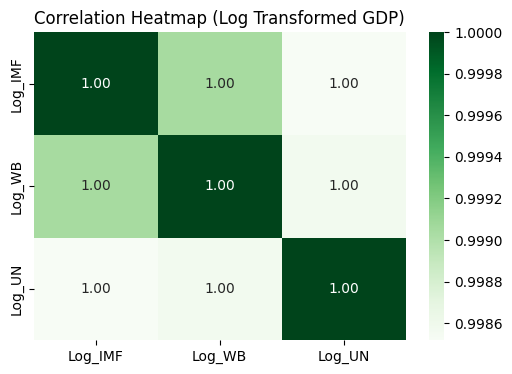

In [229]:
#Correlation Between IMF, WorldBank and UnitedNations In GDP Using Heatmap
df_log = df[log_forecast_est]

plt.figure(figsize=(6,4))
sns.heatmap(
    df_log.corr(),
    annot=True,
    cmap="Greens",
    fmt=".2f"
)
plt.title("Correlation Heatmap (Log Transformed GDP)")
plt.show()

## 📊 Key Insights from Global GDP (Nominal) Analysis

1. **Top Economies Dominate the World GDP**
   - United States 🇺🇸 remains the largest economy by a wide margin.  
   - Followed by China 🇨🇳, India 🇮🇳, Japan 🇯🇵, and Germany 🇩🇪.  
   - The Top 10 Economies account for nearly **65–70%** of the world GDP.  

2. **Distribution is Extremely Skewed**
   - Most countries have relatively small GDP compared to global giants.  
   - Normal scale shows heavy skewness, while log transformation provides a clearer relative comparison.  

3. **High Correlation Between Forecast Sources**
   - IMF, World Bank, and UN estimates are highly correlated (**r > 0.98**).  
   - This suggests consistency in global economic ranking across institutions.  

4. **Regional & Global Concentration**
   - Major economies are concentrated in North America, East Asia, and Western Europe.  
   - Africa and much of Latin America represent a small fraction of global GDP.  

5. **Data Gaps & Cleaning**
   - Several countries had missing or annotated values (e.g., `[n 1]`), which required cleaning.  
   - Highlights the importance of preprocessing even with well-known data sources.  
